In [ ]:
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel
from langgraph.types import Command


llm = init_chat_model("openai:gpt-5-mini-2025-08-07")

dumb_llm = init_chat_model("openai:gpt-5-nano-2025-08-07")
average_llm = init_chat_model("openai:gpt-5-mini-2025-08-07")
smart_llm = init_chat_model("openai:gpt-5.2-2025-12-11")

In [2]:
class State(TypedDict):
    question: str
    difficulty: str
    answer: str
    model_used: str


class DifficultyResponse(BaseModel):
    difficulty_level: Literal["easy", "medium", "hard"]


In [ ]:
def dumb_node(state: State) -> State:
    response = dumb_llm.invoke(f"Answer the following question: {state['question']}")

    return {
        "answer": response.content,
        "model_used": "gpt-5-nano",
    }


def average_node(state: State) -> State:
    response = average_llm.invoke(f"Answer the following question: {state['question']}")

    return {
        "answer": response.content,
        "model_used": "gpt-5-mini",
    }


def smart_node(state: State) -> State:
    response = smart_llm.invoke(f"Answer the following question: {state['question']}")

    return {
        "answer": response.content,
        "model_used": "gpt-5.2",
    }


def assess_difficulty(state: State) -> State:
    structured_llm = llm.with_structured_output(DifficultyResponse)

    response = structured_llm.invoke(
        f"""
        Assess the difficulty of the following question:
        Question: {state["question"]}

        - Easy: The question is straightforward and can be answered by a basic understanding of the subject.
        - Medium: The question requires a moderate level of knowledge and understanding of the subject.
        - Hard: The question is complex and requires a deep understanding of the subject.
        """,
    )

    difficulty_level = response.difficulty_level

    if difficulty_level == "easy":
        goto = "dumb_node"
    elif difficulty_level == "medium":
        goto = "average_node"
    else:
        goto = "smart_node"

    return Command(
        goto=goto,
        update={"difficulty": difficulty_level},
    )


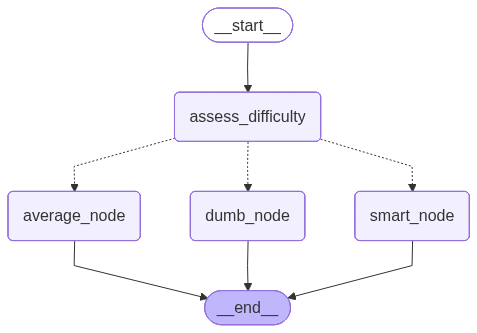

In [5]:
graph_builder = StateGraph(State)

graph_builder.add_node("dumb_node", dumb_node)
graph_builder.add_node("average_node", average_node)
graph_builder.add_node("smart_node", smart_node)
graph_builder.add_node(
    "assess_difficulty",
    assess_difficulty,
    destinations=[
        "dumb_node",
        "average_node",
        "smart_node",
    ],
)


graph_builder.add_edge(START, "assess_difficulty")


graph_builder.add_edge("dumb_node", END)
graph_builder.add_edge("average_node", END)
graph_builder.add_edge("smart_node", END)

graph = graph_builder.compile()

graph


In [10]:
graph.invoke({"dish": "pizza"})

{'dish': 'pizza',
 'ingredients': [Ingredient(name='Pizza dough', quantity='1', unit='ball'),
  Ingredient(name='Tomato sauce', quantity='1/2', unit='cup'),
  Ingredient(name='Mozzarella (shredded)', quantity='1 1/2', unit='cups'),
  Ingredient(name='Olive oil', quantity='1', unit='tablespoon'),
  Ingredient(name='Salt', quantity='1/2', unit='teaspoon'),
  Ingredient(name='Fresh basil leaves', quantity='8', unit='leaves'),
  Ingredient(name='Pepperoni slices', quantity='12', unit='slices')],
 'recipe_steps': 'Recipe: Classic Pepperoni Margherita-Style Pizza\nYields: 1 pizza (one dough ball, about 10–12" / 25–30 cm)\nPrep time: 15–30 minutes (plus 30–60 minutes if you bring dough to room temperature)\nCook time: 8–12 minutes\nTotal time: 23–102 minutes depending on dough temperature\n\nIngredients\n- 1 ball pizza dough (about 10–12" pizza)\n- 1/2 cup tomato sauce\n- 1 1/2 cups shredded mozzarella\n- 1 tablespoon olive oil\n- 1/2 teaspoon salt\n- 8 fresh basil leaves\n- 12 pepperoni slic